In [1]:
# import os
# Root = "/content/drive/MyDrive/Colab_Notebook/TSF/Traffic_sign_classification"
# os.chdir(Root)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %tensorflow_version 1.x

In [4]:
# !pip install tensorflow==2.9.1
import tensorflow as tf
# print(tf.__version__)

In [5]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [38]:
# Assigning Path for Dataset
data_dir = r'C:\Users\Redryh\Desktop\archive'
train_path = r'C:\Users\Redryh\Desktop\archive\Train'
test_path = r'C:\Users\Redryh\Desktop\Traffic Sign'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [39]:

NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [40]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

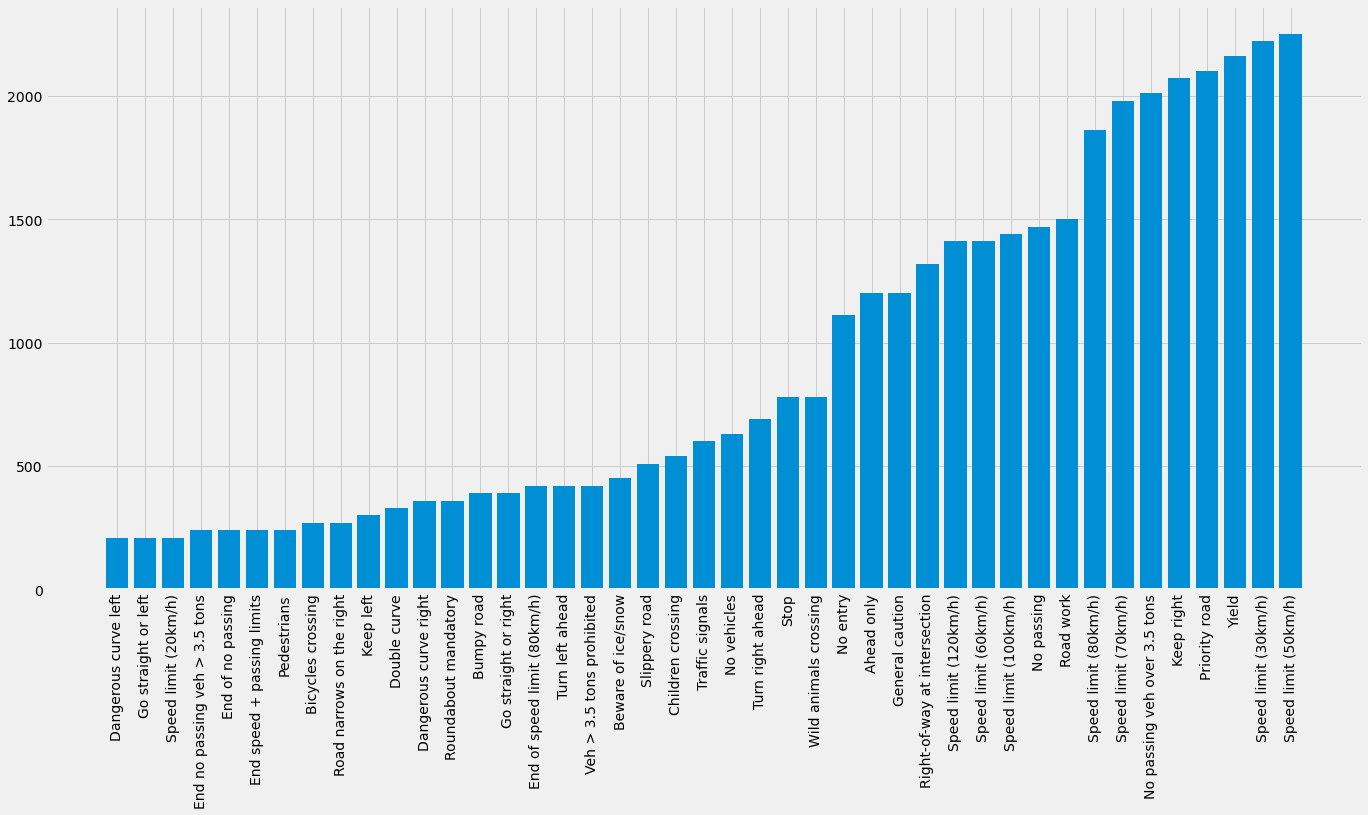

In [9]:
#Visualizing The Dataset
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

C:\Users\Redryh\AppData\Local\Temp/ipykernel_17672/1256017970.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


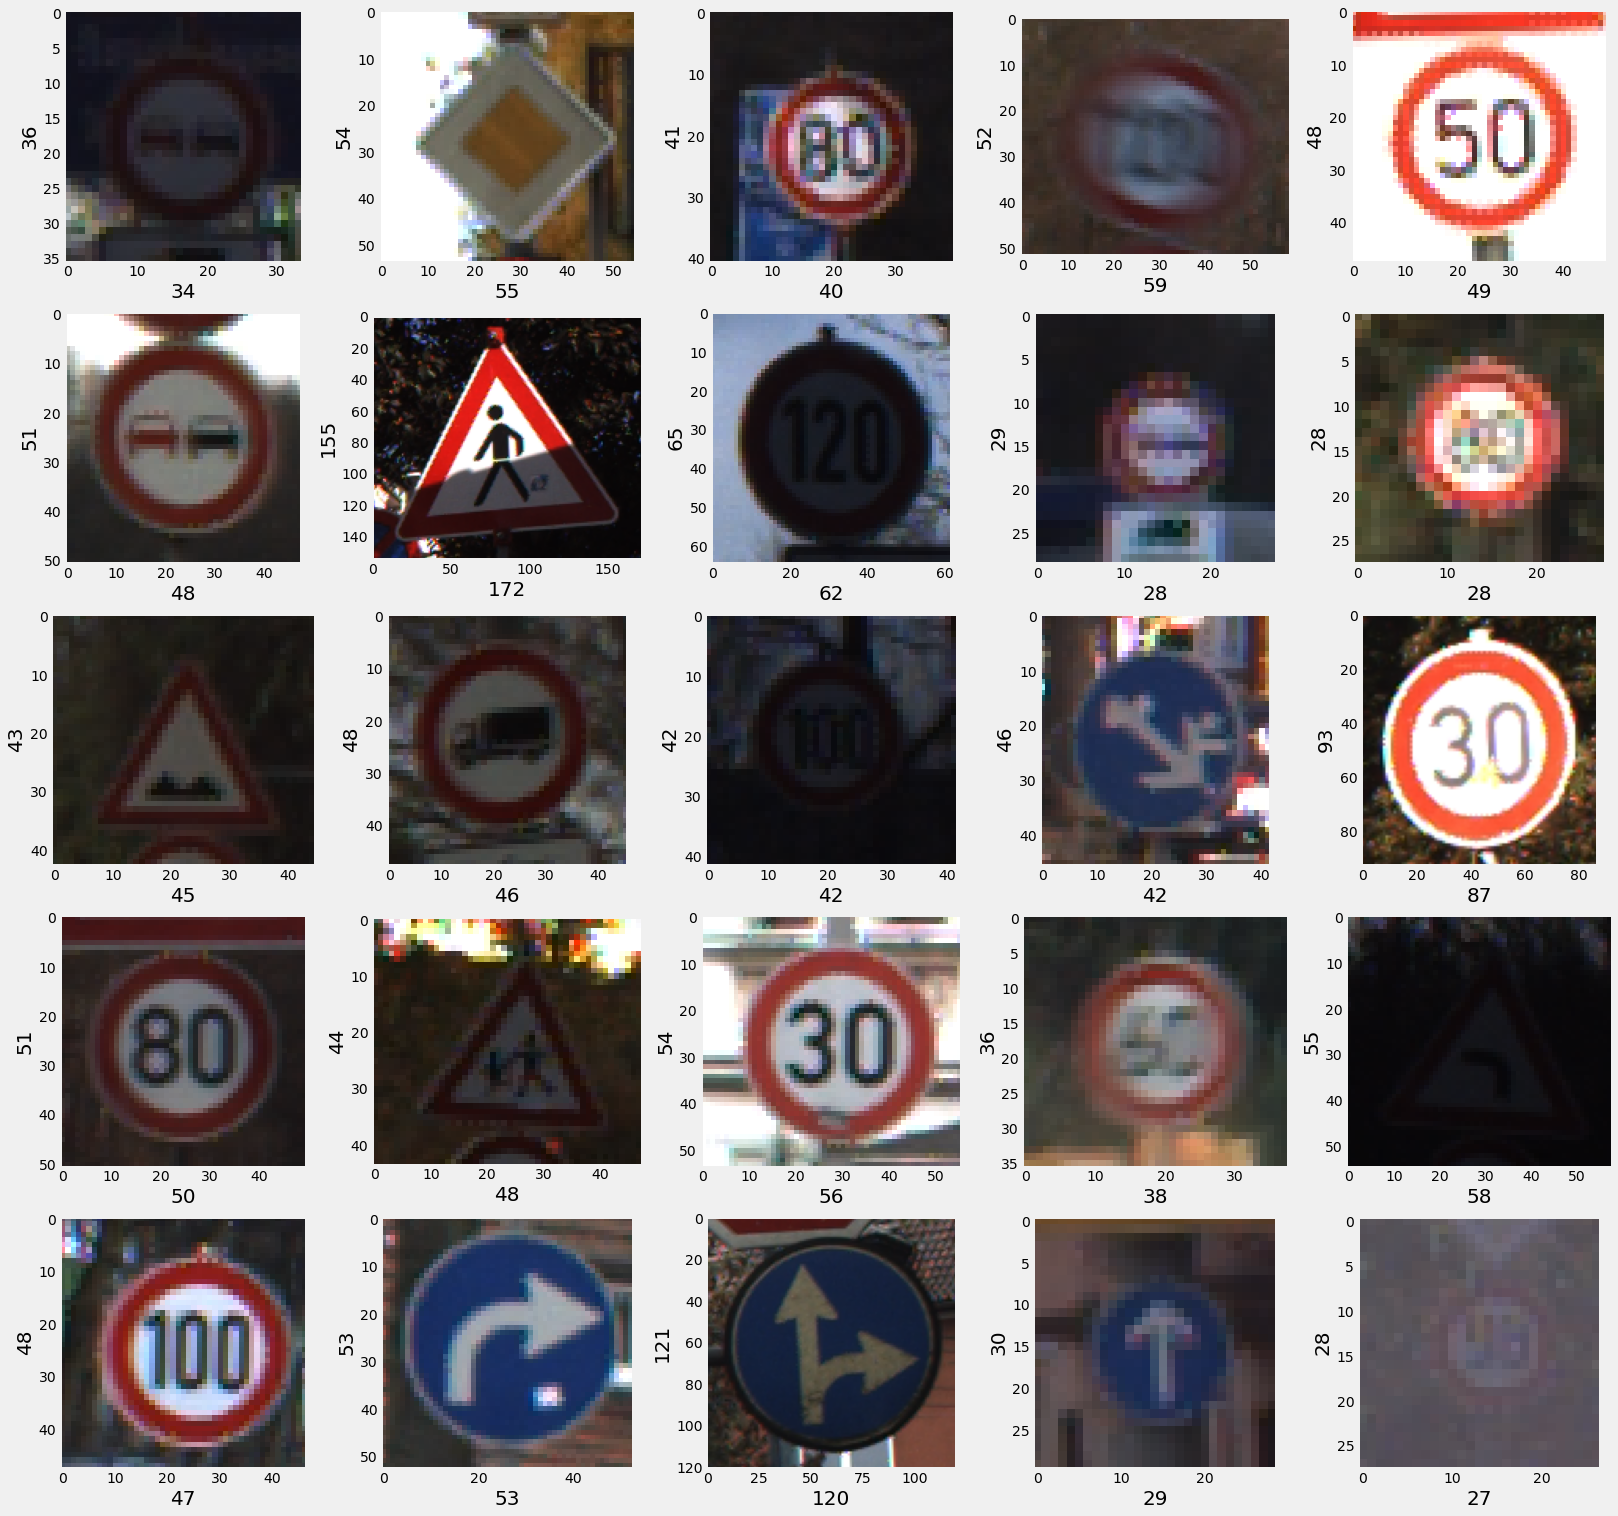

In [10]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [11]:
#Collecting the Training Data
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [12]:
#Shuffling the training data
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [13]:
#Splitting the data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [14]:
#One hot encoding the labels
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [15]:
#Making the model
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [16]:
lr = 0.001
epochs = 30

opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

C:\Users\Redryh\Desktop\Iot_1\env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 29s 33ms/step - loss: 1.1050 - accuracy: 0.7037 - val_loss: 0.0671 - val_accuracy: 0.9810
Epoch 2/30
858/858 [==============================] - 28s 32ms/step - loss: 0.1806 - accuracy: 0.9455 - val_loss: 0.0259 - val_accuracy: 0.9913
Epoch 3/30
858/858 [==============================] - 28s 33ms/step - loss: 0.1076 - accuracy: 0.9678 - val_loss: 0.0644 - val_accuracy: 0.9791
Epoch 4/30
858/858 [==============================] - 28s 33ms/step - loss: 0.0799 - accuracy: 0.9758 - val_loss: 0.0152 - val_accuracy: 0.9955
Epoch 5/30
858/858 [==============================] - 28s 33ms/step - loss: 0.0655 - accuracy: 0.9795 - val_loss: 0.0156 - val_accuracy: 0.9956
Epoch 6/30
858/858 [==============================] - 28s 33ms/step - loss: 0.0569 - accuracy: 0.9822 - val_loss: 0.0199 - val_accuracy: 0.9940
Epoch 7/30
858/858 [==============================] - 28s 33ms/step - loss: 0.0479 - accuracy: 0.9850 - val_loss: 0.0113 - val_accuracy:

In [18]:
model.save("model.h5")

In [19]:
model.save_weights("/content/drive/MyDrive/Colab_Notebook/TSF/Traffic_sign_classification/output")

In [20]:

dir(aug)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_validation_split',
 'apply_transform',
 'brightness_range',
 'channel_axis',
 'channel_shift_range',
 'col_axis',
 'cval',
 'data_format',
 'dtype',
 'featurewise_center',
 'featurewise_std_normalization',
 'fill_mode',
 'fit',
 'flow',
 'flow_from_dataframe',
 'flow_from_directory',
 'get_random_transform',
 'height_shift_range',
 'horizontal_flip',
 'interpolation_order',
 'mean',
 'preprocessing_function',
 'random_transform',
 'rescale',
 'rotation_range',
 'row_axis',
 'samplewise_center',
 'samplewise_std_normalization',
 'shear_range',
 'standardize',
 'std',
 'vertica

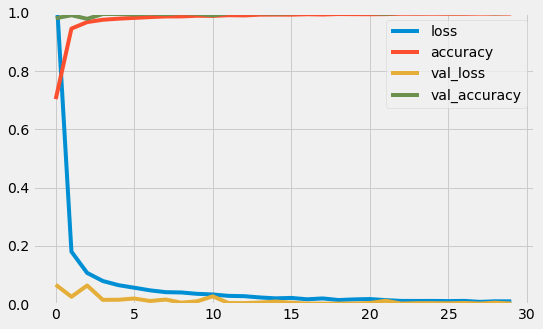

In [21]:
#Evaluating the model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [22]:
test = pd.read_csv(data_dir + '/Test.csv')

label = test["ClassId"].values
imgs = test["Path"].values

data = []

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' + img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT,IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

#pred = model.predict_classes(X_test)
pred_x = model.predict(X_test)
pred =np.argmax(pred_x,axis=1)
# Accuracy with the test data
print('Test Data accuracy: ', accuracy_score(label, pred)*100)

395/395 [==============================] - 3s 8ms/step
Test Data accuracy:  98.66191607284243


In [25]:
#Visualizing the confusion matrix
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(label, pred)

In [27]:
from sklearn.metrics import classification_report

print(classification_report(label, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
           2       0.99      1.00      1.00       750
           3       0.98      0.97      0.98       450
           4       1.00      0.99      0.99       660
           5       0.97      0.99      0.98       630
           6       1.00      0.99      0.99       150
           7       1.00      1.00      1.00       450
           8       0.99      0.98      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.91      1.00      0.95       420
          12       1.00      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.99      1.00      1.00       210
          16       1.00      1.00      1.00       150
          17       1.00    

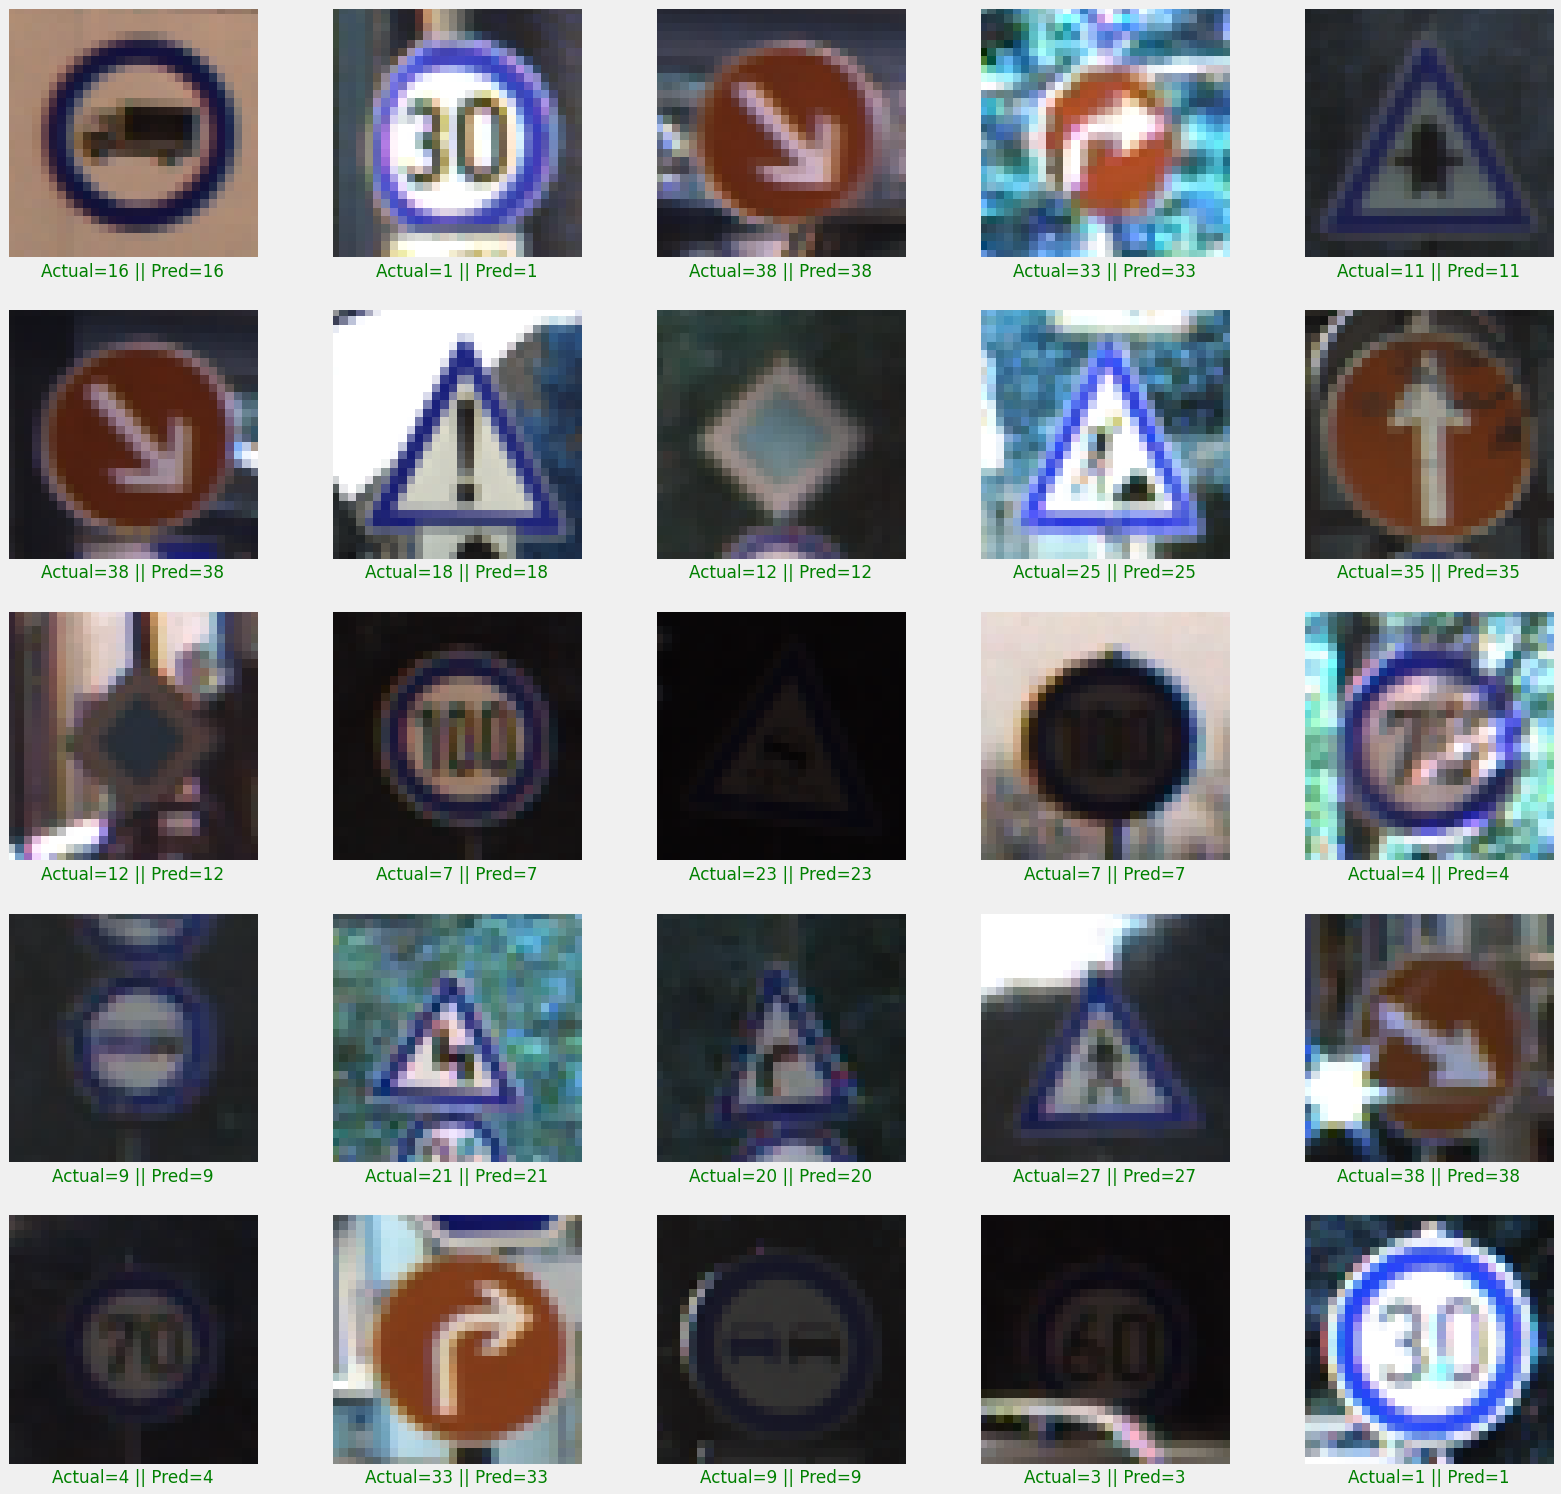

In [42]:
#Predictions on Test Data
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = label[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [33]:

ls

 Volume in drive C is OS
 Volume Serial Number is 72AF-E00F

 Directory of C:\Users\Redryh\Desktop\Iot_1

01/06/2022  01:44 PM    <DIR>          .
01/06/2022  01:40 PM    <DIR>          ..
31/05/2022  02:12 PM    <DIR>          .ipynb_checkpoints
06/03/2022  12:01 PM                 0 conda
20/03/2022  11:50 AM           269,615 CV_1.ipynb
06/03/2022  11:01 AM    <DIR>          env
09/03/2022  07:05 PM            11,593 gragsolidWhiteRight.jpg
01/06/2022  12:44 PM        14,133,180 model.h5
30/03/2022  01:41 PM             3,982 n1.ipynb
23/03/2022  09:01 PM                 0 output
23/03/2022  09:08 PM                 0 output.mp4
30/03/2022  01:44 PM             2,294 Shile.ipynb
23/03/2022  07:30 PM         2,641,803 solidWhiteRight..mp4
06/03/2022  12:02 PM            70,682 solidWhiteRight.jpg
01/06/2022  01:44 PM         1,116,486 Tarfic_signal.ipynb
01/06/2022  01:25 PM    <DIR>          Traffic Sign
31/05/2022  01:31 PM        53,960,789 Traffic_sign_classification-main.zip
11/

In [37]:
model_path = "model.h5"
loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np

def imgerecog(x):

    image = cv2.imread("C:\Users\Redryh\Desktop\Traffic Sign"+srt.png")

    image_fromarray = Image.fromarray(image, 'RGB')
    resize_image = image_fromarray.resize((30, 30))
    expand_input = np.expand_dims(resize_image,axis=0)
    input_data = np.array(expand_input)
    input_data = input_data/255

    pred = loaded_model.predict(input_data)
    result = pred.argmax()
    result

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (Temp/ipykernel_17672/1239855076.py, line 9)